In [33]:
from Likelihoods import WishartProcessLikelihood
from Models import WishartProcess
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary

import numpy as np
from numpy.random import uniform, normal
np.random.seed(0)
import matplotlib.pyplot as plt

### Generate synthetic data & visualize results

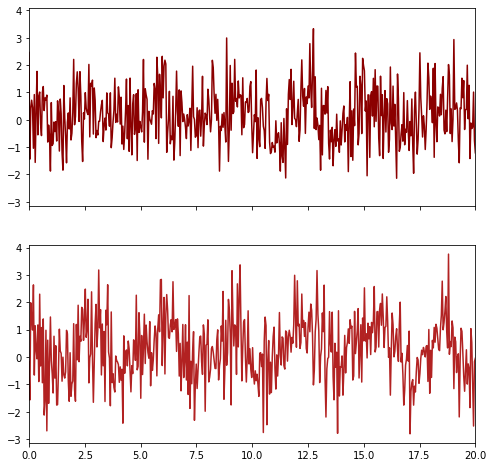

In [70]:
N, D = 500, 2
T = 20
X = np.array([np.linspace(0,T,N) for i in range(D)]).T
noise = normal(0, 1, (N,D))
Y= uniform(0.5, 1.5, D)*np.cos(X+uniform(0,2*np.pi))*np.sin(X+uniform(0,2*np.pi)) + noise
data = (X,Y)

fig, ax = plt.subplots(D,1, sharex=True, sharey=True, figsize=(8,8))
if not isinstance(ax, np.ndarray):
    ax=[ax]
colors = ['darkred', 'firebrick', 'red', 'salmon']
for i in range(D):
    ax[i].plot(X[:,i], Y[:,i],color=colors[i])
    ax[i].set_xlim((0,T))
    if i==2:          
        ax[i].set_ylabel('measurement')
    if i==3:
        ax[i].set_xlabel('time')
plt.show()

### Model initialization

In [71]:
## Model parameters
DoF = 1 #D # Degrees of freedom 
R = 10 # samples for variational expectation
M = 50 # num inducing points
Z_init = np.array([np.linspace(0, T, M) for i in range(D)]).T #.reshape(M,1) # initial inducing variable locations
max_iter = 2000

kernel = gpflow.kernels.SharedIndependent(gpflow.kernels.SquaredExponential() + gpflow.kernels.Linear(), output_dim=D)
#likelihood = WishartProcessLikelihood.InvWishartProcessLikelihood(D, DoF, R)
likelihood = gpflow.likelihoods.Gaussian()
Z = Z_init.copy()
iv = gpflow.inducing_variables.SharedIndependentInducingVariables(
    gpflow.inducing_variables.InducingPoints(Z)) # multi output inducing variables

wishart_process = WishartProcess.InvWishartProcess(kernel, likelihood, D=D, DoF=DoF, inducing_variable=iv)

print_summary(wishart_process)

╒═════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════╕
│ name                                                    │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value            │
╞═════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════╡
│ InvWishartProcess.kernel.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 1.0              │
├─────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ InvWishartProcess.kernel.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 1.0              │
├───────────────────────────────────────────────────

Train model & visualize results

In [72]:
def optimize_model_with_scipy(model):
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure(data),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": max_iter},
    )
def plot_model(model):
    pY, pYv = model.predict_y(X)

    fig, ax = plt.subplots(D,1, sharex=True, sharey=True, figsize=(8,8))
    if not isinstance(ax, np.ndarray):
        ax=[ax]
    colors = ['darkred', 'firebrick', 'red', 'salmon']
    for i in range(D):
        # data
        ax[i].plot(X[:,i], Y[:,i],color='black', label='Observations')
        # mean
        ax[i].plot(X[:,i], pY[:,i],color=colors[i],label='Posterior mean')
        ax[i].set_xlim((0,T))
        
        # 2*std
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        ax[i].fill_between(X[:,i], top, bot, alpha=0.3, color=colors[i], label='2$\sigma$')
        if i==2:          
            ax[i].set_ylabel('measurement')
        if i==3:
            ax[i].set_xlabel('time')
    handles, labels = ax[-1].get_legend_handles_labels()    
    fig.suptitle(f"ELBO: {model.elbo(data):.3}")
    plt.tight_layout()    
    fig.legend(handles, labels, loc='center right')
    plt.show()

╒═════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                                    │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                                                │
╞═════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════════════════╡
│ InvWishartProcess.kernel.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()          │ float64 │ 0.2408532959427281                                   │
├─────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ InvWishartProcess.kernel.ker

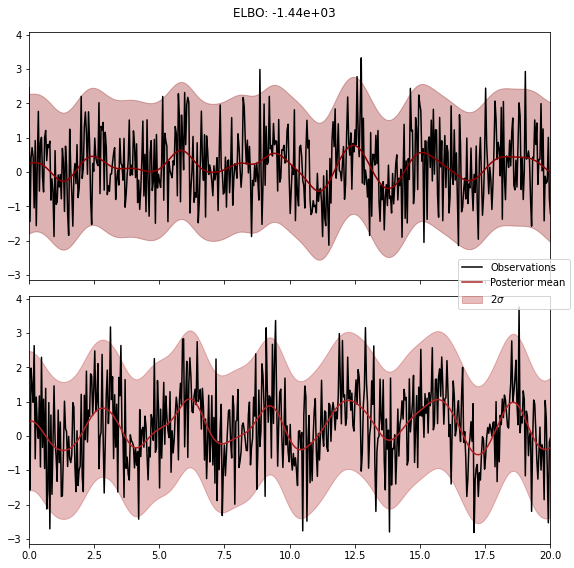

In [73]:
optimize_model_with_scipy(model=wishart_process)
print_summary(wishart_process)
plot_model(wishart_process)


